In [1]:
import pandas as pd
import sklearn
import random
import time,datetime
import requests
import scipy as sp
import sklearn.metrics as met
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep

from io import BytesIO
from sklearn.cluster import KMeans
from numpy.random import random_sample
from math import sqrt, log
%matplotlib inline

## Set seed

In [2]:
seed = 42

## Read data

### original data

In [2]:
data = pd.read_csv(r'.\Tianchi_power\Tianchi_power.csv',parse_dates = [0],
                   dtype = {'power_consumption': np.int16, 'user_id': np.int16},
                   #na_values =[1],
                   encoding = 'gbk')
# fill missing value with 0
data_Org =data.pivot_table(values = 'power_consumption',index = 'record_date',
                           columns = 'user_id',fill_value = 0)
data_Org = data_Org.transpose()


## filled by a stupid scheme

In [3]:
data_Filled = pd.read_csv('data_Filled.csv',index_col = [0],parse_dates = True)
data_Filled.columns = pd.to_datetime(data_Filled.columns)

holidayData = pd.read_csv(r'date.csv',parse_dates = [0])
holidayData_Org = holidayData
holidayData = holidayData.set_index('date')

#weather = pd.read_csv(r'yangzhong_weather.csv',parse_dates = [0])
weather = pd.read_csv('yangzhong_weather.csv',parse_dates = [0])
weather = weather.set_index('date')

In [5]:
data_Filled_bak = data_Filled
data_Filled = data_Org

In [6]:
data_Filled.columns = pd.to_datetime(data_Filled.columns)

In [7]:
def rsme_F(prediction,realValue):
    return sum([((prediction[i]-realValue[i])/realValue[i])**2 for i in range(len(realValue))])/len(realValue)

In [8]:
def sort_dict(d):
    return sorted(d.items(), key = lambda k:k[1], reverse = True)

## Predict using xgboost

In [9]:
import xgboost as xgb

C:\Users\lenovo\AppData\Roaming\Python\Python35\site-packages\sklearn\cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


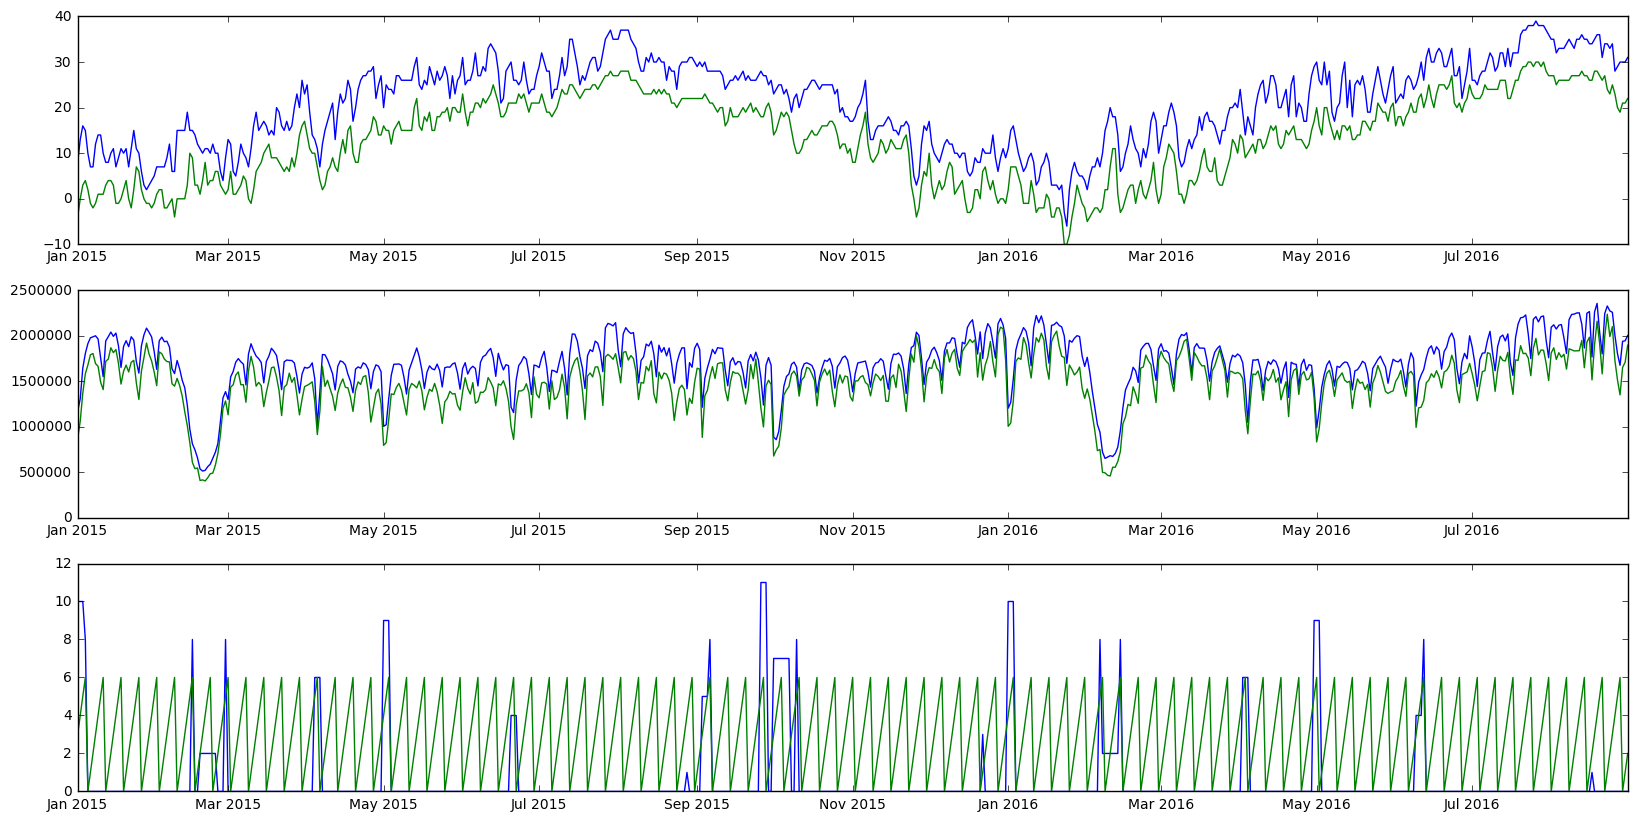

In [10]:
plt.figure(figsize = [20,10])
plt.subplot(3,1,1)
plt.plot(weather.index[:-30],weather.high_T[:-30])
plt.plot(weather.index[:-30],weather.low_T[:-30])
#plt.plot(weather2.date[:-30],weather.low_T[:-30])

plt.subplot(3,1,2)
plt.plot(data_Filled_bak.sum())
plt.plot(data_Filled.sum())

plt.subplot(3,1,3)
plt.plot(weather.index[:-30],holidayData_Org.date_type[:639].astype('category').cat.codes[:-30])
plt.plot(weather.index[:-30],holidayData_Org.dayOfWeek[:639].astype('category').cat.codes[:-30])

## 检测：电耗数据的波谷

In [11]:
def checkValley(dataSeries,threshold = 0.1):
    l = len(dataSeries)
    i = 1
    valleyIdx = []
    start, end = 0,0
    while i<l-1:
        if not start:
            if dataSeries[i] < (1-threshold)*dataSeries[i-1]: # valley starts
                start = i
        if not end:
            if dataSeries[i] < (1-threshold)*dataSeries[i + 1]: # valley ends
                end = i
                valleyIdx.append(start +np.argmin(dataSeries[start:end+1]))
                start,end = 0,0
        i += 1
    return valleyIdx

In [12]:
weekend_Idx = np.logical_or(holidayData_Org.dayOfWeek[:639]==6,holidayData_Org.dayOfWeek[:639]==7)
changePoints = [i in checkValley(list(data_Filled.sum())) for i in np.arange(len(data_Filled.sum()))]
holiday_Idx =(holidayData_Org.date_type[:639]) != '0'

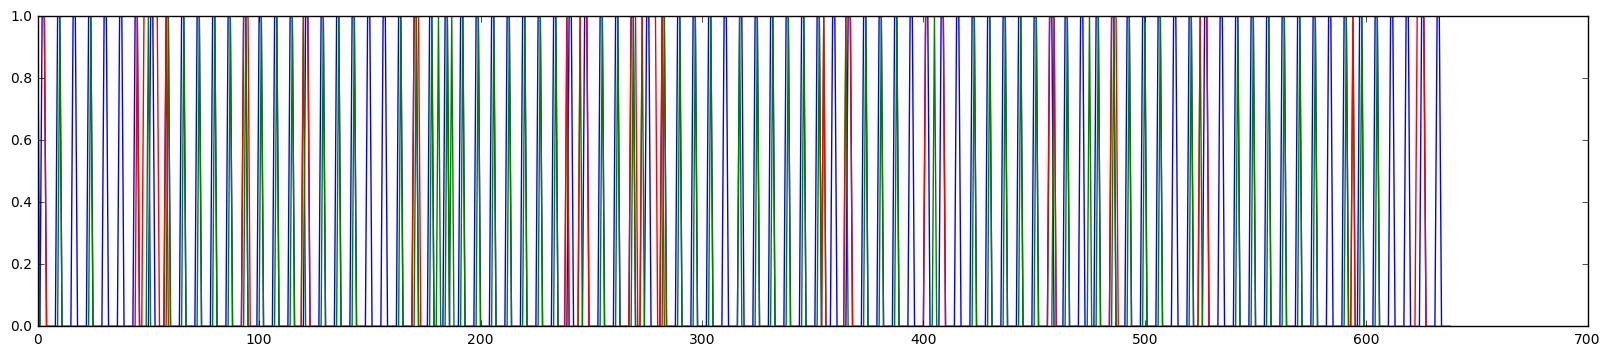

In [13]:
plt.figure(figsize = [20,4])
plt.plot(weekend_Idx)
plt.plot(changePoints)
plt.plot(holiday_Idx)

In [14]:
for i,b in enumerate(changePoints):
    if b:
        if not(weekend_Idx[i] or holiday_Idx[i]):
            print(i)

181
187
475


In [15]:
data_Filled.sum().index[239]  #鬼节！！

Timestamp('2015-08-28 00:00:00')

In [16]:
data_Filled.sum().index[594]  #鬼节！！

Timestamp('2016-08-17 00:00:00')

In [183]:
enc = prep.OneHotEncoder(n_values = 'auto',sparse = False)
xbin = enc.fit_transform(holidayData.date_type[:639].astype('category').cat.codes.reshape(-1,1))
holidayData_OneHot = pd.DataFrame(xbin,columns = ['holidayData_'+name 
                                           for name in holidayData.date_type[:639].astype('category').cat.categories])
holidayData_OneHot = holidayData_OneHot.rename_axis(dict(zip(np.arange(holidayData.shape[0]),weather.index)),axis = 0)

In [18]:
enc = prep.OneHotEncoder(n_values = 'auto',sparse = False)
xbin = enc.fit_transform(weather.skycon2[:639].astype('category').cat.codes.reshape(-1,1))
skycon_OneHot = pd.DataFrame(xbin,columns = ['skycon_'+name 
                                           for name in weather.skycon2[:639].astype('category').cat.categories])
skycon_OneHot = skycon_OneHot.rename_axis(dict(zip(np.arange(weather.shape[0]),weather.index)),axis = 0)

In [19]:
dataForXGB = weather

dataForXGB['dayOfMonth'] = dataForXGB.index.day
dataForXGB['dayOfYear'] = dataForXGB.index.dayofyear
dataForXGB['dayOfWeek'] = holidayData.dayOfWeek
dataForXGB['week'] = dataForXGB.index.week
dataForXGB['month'] = dataForXGB.index.month
dataForXGB['year'] = dataForXGB.index.year

dataForXGB['dateInt'] = dataForXGB.index.astype(np.int64)
dataForXGB['weekend'] = np.logical_and(np.logical_or(holidayData.dayOfWeek == 6,holidayData.dayOfWeek == 7),holidayData.date_type ==0)

dataForXGB = dataForXGB.join(holidayData_OneHot).drop(['skycon','skycon2'],axis = 1)

dataForXGB = dataForXGB.join(skycon_OneHot)

In [20]:
dataForXGB = dataForXGB.drop(['skycon_rain','skycon_snow','skycon_clear_day','skycon_cloudy'],axis = 1)

In [21]:
dataForXGB.sort_index(1).head()

,dateInt,dayOfMonth,dayOfWeek,dayOfYear,high_T,holidayData_0,holidayData_Guijie,holidayData_chunjie,holidayData_dongzhi,holidayData_duanwu,...,holidayData_shiyi,holidayData_wd_Shift,holidayData_wuyi,holidayData_yuandan,holidayData_zhongqiu,low_T,month,week,weekend,year
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1420070400000000000,1,4,1,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-4,1,1,False,2015
2015-01-02,1420156800000000000,2,5,2,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,1,1,False,2015
2015-01-03,1420243200000000000,3,6,3,16,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3,1,1,False,2015
2015-01-04,1420329600000000000,4,7,4,15,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,4,1,1,False,2015
2015-01-05,1420416000000000000,5,1,5,10,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,1,2,False,2015


### Model1: no historical data, score =0

In [22]:
dataForXGB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2015-01-01 to 2016-09-30
Data columns (total 22 columns):
high_T                  639 non-null int64
low_T                   639 non-null int64
dayOfMonth              639 non-null int32
dayOfYear               639 non-null int32
dayOfWeek               639 non-null int64
week                    639 non-null int32
month                   639 non-null int32
year                    639 non-null int32
dateInt                 639 non-null int64
weekend                 639 non-null bool
holidayData_0           639 non-null float64
holidayData_Guijie      639 non-null float64
holidayData_chunjie     639 non-null float64
holidayData_dongzhi     639 non-null float64
holidayData_duanwu      639 non-null float64
holidayData_kangri      639 non-null float64
holidayData_qingming    639 non-null float64
holidayData_shiyi       639 non-null float64
holidayData_wd_Shift    639 non-null float64
holidayData_wuyi        639 non-null float

In [23]:
def modelWithHistoryData(dataX,dataY,weight = []):
    seed = 42
    if not len(weight):
        weight = [1]*len(dataY)
    dTrain1 = xgb.DMatrix(dataX.iloc[:578,:],dataY[:578],weight = weight[:578])
    dTest1 = xgb.DMatrix(dataX.iloc[578:609,:],dataY[578:609], weight = weight[578:609])
    
    num_round = 1000
    evallist1 = [(dTrain1,'train'),(dTest1,'test')]

    param = {'bst:max_depth':12,
             'bst:eta':0.01,
             'subsample':0.8,
             'colsample_bytree':0.7,
             'silent':1,
             'objective':'reg:linear',
             'nthread':6,
             'eval_metric':'rmse',
             'seed':seed}

    plst = param.items()

    bst = xgb.train(plst, dTrain1, num_round, evallist1, 
                    verbose_eval=20, 
                    #obj = logregobj,
                    #feval = rcme,
                early_stopping_rounds=250)
    return bst,bst.predict(dTest1)

In [73]:
dataX1 = dataForXGB.iloc[:-30,:]
dataY1 = data_Filled.sum()
#dataY1 = data_Org.sum()

bst,preds1_1 = modelWithHistoryData(dataX1,dataY1)

[0]	train-rmse:1.06384e+06	test-rmse:1.37633e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:54894.6	test-rmse:186102
[40]	train-rmse:33432.4	test-rmse:181344
[60]	train-rmse:20015.2	test-rmse:180043
[80]	train-rmse:13149.3	test-rmse:171710
[100]	train-rmse:9075.28	test-rmse:173662
[120]	train-rmse:6479.02	test-rmse:174488
[140]	train-rmse:4276.5	test-rmse:175019
[160]	train-rmse:2957.62	test-rmse:174308
[180]	train-rmse:2083.56	test-rmse:174724
[200]	train-rmse:1494.8	test-rmse:174930
[220]	train-rmse:1035.36	test-rmse:174600
[240]	train-rmse:705.769	test-rmse:174674
[260]	train-rmse:474.608	test-rmse:174656
[280]	train-rmse:336.84	test-rmse:174726
[300]	train-rmse:237.274	test-rmse:174797
[320]	train-rmse:166.181	test-rmse:174799
Stopping. Best iteration:
[78]	train-rmse:13922.9	test-rmse:171615



In [74]:
featureImp = bst.get_fscore()
newList = sorted(featureImp.items(), key = lambda k:k[1],reverse = True)

In [75]:
newList

[('dayOfYear', 2352),
 ('high_T', 1903),
 ('dayOfMonth', 1819),
 ('low_T', 1494),
 ('dateInt', 1480),
 ('dayOfWeek', 1276),
 ('week', 477),
 ('holidayData_0', 95),
 ('year', 73),
 ('month', 52),
 ('holidayData_wd_Shift', 32),
 ('holidayData_chunjie', 23),
 ('holidayData_wuyi', 22),
 ('holidayData_duanwu', 19),
 ('holidayData_kangri', 18),
 ('holidayData_qingming', 15),
 ('holidayData_shiyi', 12),
 ('holidayData_zhongqiu', 4),
 ('holidayData_dongzhi', 2),
 ('holidayData_Guijie', 1),
 ('holidayData_yuandan', 1)]

In [521]:
bst,preds1_2 = modelWithHistoryData(dataX1,dataY1,weight = np.array(changePoints)*(0)+1)

[0]	train-rmse:1.20683e+06	test-rmse:1.57881e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:46654.5	test-rmse:134394
[40]	train-rmse:23521.7	test-rmse:117283
[60]	train-rmse:14986.1	test-rmse:119406
[80]	train-rmse:9845.66	test-rmse:117389
[100]	train-rmse:6487.07	test-rmse:115056
[120]	train-rmse:4578.82	test-rmse:114323
[140]	train-rmse:3068.41	test-rmse:114769
[160]	train-rmse:2162.13	test-rmse:115451
[180]	train-rmse:1582.93	test-rmse:116005
[200]	train-rmse:1091.27	test-rmse:116228
[220]	train-rmse:817.31	test-rmse:116589
[240]	train-rmse:580.378	test-rmse:116680
[260]	train-rmse:443.792	test-rmse:116636
[280]	train-rmse:313.097	test-rmse:116529
[300]	train-rmse:224.918	test-rmse:116532
[320]	train-rmse:166.896	test-rmse:116591
[340]	train-rmse:121.966	test-rmse:116567
[360]	train-rmse:87.8968	test-rmse:116590
Stopping. Best iteration:
[123]	train-rmse:4224.74	test-

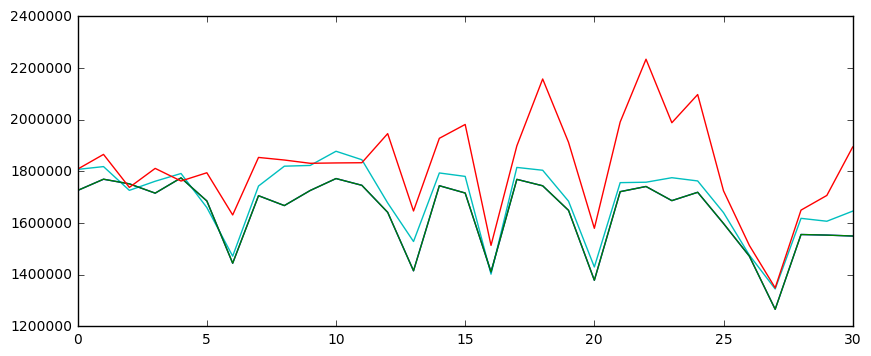

In [202]:
##
plt.figure(figsize = [10,4])
plt.plot(np.arange(31),preds1_1,'c')
#plt.plot(np.arange(31),result1,'b')
#plt.plot(np.arange(31),preds1_2,'k')
plt.plot(np.arange(31),preds2_1,'b')
plt.plot(np.arange(31),prediction2_OneByOne_NoRE,'g')
plt.plot(np.arange(31),data_Filled.sum()[578:609],'r');
#plt.plot(np.arange(31),data_Filled_bak.sum()[578:609],'g');

In [203]:
#print('RSME of model2:  '+str(rsme_F(preds1_1,data_Filled_bak.sum()[578:609])))
print('RSME of model1:  '+str(rsme_F(preds1_1,data_Filled.sum()[578:609])))
#print('RSME of model1:  '+str(rsme_F(result1,data_Filled.sum()[578:609])))
#print('RSME of model1:  '+str(rsme_F(preds1_2,data_Filled.sum()[578:609])))
print('RSME of model3:  '+str(rsme_F(preds2_1,data_Filled.sum()[578:609])))
print('RSME of model3:  '+str(rsme_F(prediction2_OneByOne_NoRE,data_Filled.sum()[578:609])))

RSME of model1:  0.0076798334417
RSME of model3:  0.0121230353643
RSME of model3:  0.0121230353643


## try the RMSLE metric

In [112]:
dataForXGB.shape

(639, 22)

In [113]:
dataX2 = dataForXGB.iloc[:-30,:]
dataY2 = np.log(data_Filled.sum()+1)

In [114]:
bst2,preds1_2 = modelWithHistoryData(dataX2,dataY2)
preds1_2 = np.exp(preds1_2)-1

[0]	train-rmse:9.58557	test-rmse:9.81562
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:0.057379	test-rmse:0.11832
[40]	train-rmse:0.029325	test-rmse:0.101125
[60]	train-rmse:0.018455	test-rmse:0.101221
[80]	train-rmse:0.012471	test-rmse:0.101653
[100]	train-rmse:0.008648	test-rmse:0.100131
[120]	train-rmse:0.006274	test-rmse:0.100852
[140]	train-rmse:0.004564	test-rmse:0.0998
[160]	train-rmse:0.003244	test-rmse:0.098527
[180]	train-rmse:0.002247	test-rmse:0.098703
[200]	train-rmse:0.001626	test-rmse:0.09853
[220]	train-rmse:0.00114	test-rmse:0.098951
[240]	train-rmse:0.000926	test-rmse:0.099317
[260]	train-rmse:0.000825	test-rmse:0.099238
[280]	train-rmse:0.000785	test-rmse:0.09932
[300]	train-rmse:0.000778	test-rmse:0.099309
[320]	train-rmse:0.000754	test-rmse:0.099159
[340]	train-rmse:0.00074	test-rmse:0.099221
[360]	train-rmse:0.00073	test-rmse:0.099224
[380]	train-rmse:

## prepare data for prediction

In [104]:
dataForXGB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2015-01-01 to 2016-09-30
Data columns (total 22 columns):
high_T                  639 non-null int64
low_T                   639 non-null int64
dayOfMonth              639 non-null int32
dayOfYear               639 non-null int32
dayOfWeek               639 non-null int64
week                    639 non-null int32
month                   639 non-null int32
year                    639 non-null int32
dateInt                 639 non-null int64
weekend                 639 non-null bool
holidayData_0           639 non-null float64
holidayData_Guijie      639 non-null float64
holidayData_chunjie     639 non-null float64
holidayData_dongzhi     639 non-null float64
holidayData_duanwu      639 non-null float64
holidayData_kangri      639 non-null float64
holidayData_qingming    639 non-null float64
holidayData_shiyi       639 non-null float64
holidayData_wd_Shift    639 non-null float64
holidayData_wuyi        639 non-null float

In [107]:
dataForXGB.to_pickle('dataForResult.pkl')
data_Filled.to_pickle('dataY.pkl')

## divide dataset

In [44]:
def modelWithHistoryData2(dataX,dataY,two_step = False):
    seed = 42
    dTrain1 = xgb.DMatrix(dataX.iloc[:-31,:],dataY[:-31])
    dTest1 = xgb.DMatrix(dataX.iloc[-31:,:],dataY[-31:])
    
    num_round = 1000
    evallist1 = [(dTrain1,'train'),(dTest1,'test')]

    param = {'bst:max_depth':12,
             'bst:eta':0.01,
             'subsample':0.8,
             'colsample_bytree':0.7,
             'silent':1,
             'objective':'reg:linear',
             'nthread':6,
             'eval_metric':'rmse',
             'seed':seed}

    plst = param.items()

    bst = xgb.train(plst, dTrain1, num_round, evallist1, 
                    verbose_eval=False, 
                    #obj = logregobj,
                    #feval = rcme,
                early_stopping_rounds=250)
    if two_step:
        dTrain2 = xgb.DMatrix(dataX,dataY)
        num_round = bst.best_iteration
        
        bst = xgb.train(plst, dTrain2, num_round, evallist1, 
                    verbose_eval=False, 
                    #obj = logregobj,
                    #feval = rcme,
                    early_stopping_rounds=250)

    return bst,bst.predict(dTest1),bst.predict(dTrain1)

In [28]:
data_Temp = data_Filled.sum(axis = 1)

In [29]:
def listAccumulate(l):
    result = []
    for i,value in enumerate(l):
        result.append(sum(l[:i]))
    return result[1:]+[sum(l)]

In [30]:
s = listAccumulate(data_Temp.sort_values()[::-1])

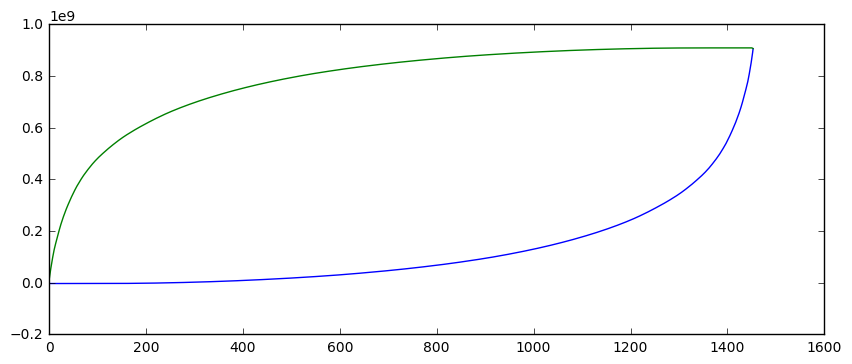

In [31]:
plt.figure(figsize = [10,4])
plt.plot(listAccumulate(data_Temp.sort_values()))
plt.plot(listAccumulate(data_Temp.sort_values()[::-1]))

In [32]:
for i,si in enumerate(s):
    if si/max(s) >.5:
        print(0.5,i,si)
        break
for i,si in enumerate(s):
    if si/max(s) >.75:
        print(0.75,i,si)
        break
for i,si in enumerate(s):
    if si/max(s) >.9:
        print(0.9,i,si)
        break

0.5 87 455382074
0.75 277 682182922
0.9 575 818396601


In [33]:
sorted_data = data_Temp.sort_values()[::-1]

In [34]:
sorted_data

user_id
743     15435708
1139    13611545
1070    12716087
1385    12566143
1165    11507953
1181    11254628
1346    10796744
1112    10723223
1146    10153079
1414     9793425
1197     9207340
77       8400342
514      7486073
274      7443029
278      7320032
149      7200328
966      7175411
759      7150411
1033     7000103
722      6935612
947      6886047
138      6794093
291      6690615
86       6504601
1058     5954679
1355     5950504
1134     5835196
1415     5756623
1213     5521023
941      5299876
          ...   
586          609
588          609
676          609
650          609
652          609
653          609
675          609
674          609
673          609
672          609
671          609
589          609
669          609
668          609
667          609
666          609
665          609
664          609
663          609
661          609
658          609
657          609
656          609
655          609
549          609
654          609
670          609
90    

In [35]:
dataForXGB.head()

,high_T,low_T,dayOfMonth,dayOfYear,dayOfWeek,week,month,year,dateInt,weekend,...,holidayData_chunjie,holidayData_dongzhi,holidayData_duanwu,holidayData_kangri,holidayData_qingming,holidayData_shiyi,holidayData_wd_Shift,holidayData_wuyi,holidayData_yuandan,holidayData_zhongqiu
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,8,-4,1,1,4,1,1,2015,1420070400000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-01-02,13,0,2,2,5,1,1,2015,1420156800000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-01-03,16,3,3,3,6,1,1,2015,1420243200000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-01-04,15,4,4,4,7,1,1,2015,1420329600000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-05,10,2,5,5,1,2,1,2015,1420416000000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
dataX1 = dataForXGB.iloc[:-30,:]
dataY1 = data_Filled.iloc[742,:]
#dataY1 = data_Org.sum()

bst,preds743_1,preds743_2 = modelWithHistoryData2(dataX1,dataY1)

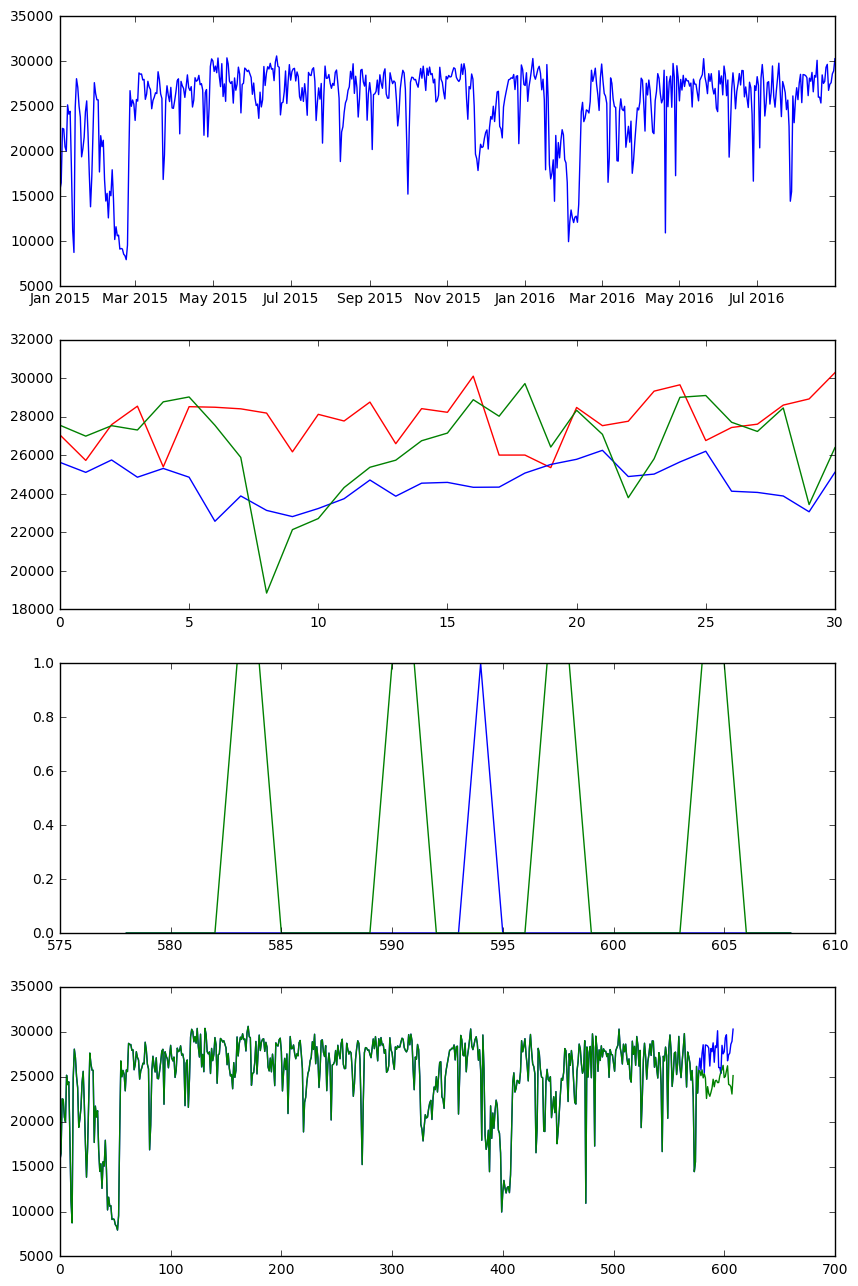

In [211]:
## 743
plt.figure(figsize = [10,16])
plt.subplot(4,1,1)
plt.plot(data_Filled.iloc[742,:])
plt.subplot(4,1,2)
plt.plot(list(dataY1[-31:]),color = 'r')
plt.plot(preds743_1,color = 'b')
plt.plot(list(dataY1[-31-366:-366]),color = 'g')
plt.subplot(4,1,3)
plt.plot(holiday_Idx[-61:-30])
plt.plot(weekend_Idx[-61:-30])
plt.subplot(4,1,4)
plt.plot(list(dataY1))
plt.plot(list(preds743_2)+list(preds743_1))

In [212]:
dataX1 = dataForXGB.iloc[:-30,:]
dataY1 = data_Filled.iloc[1138,:]
#dataY1 = data_Org.sum()

bst,preds1138_1,preds1138_2 = modelWithHistoryData2(dataX1,dataY1)

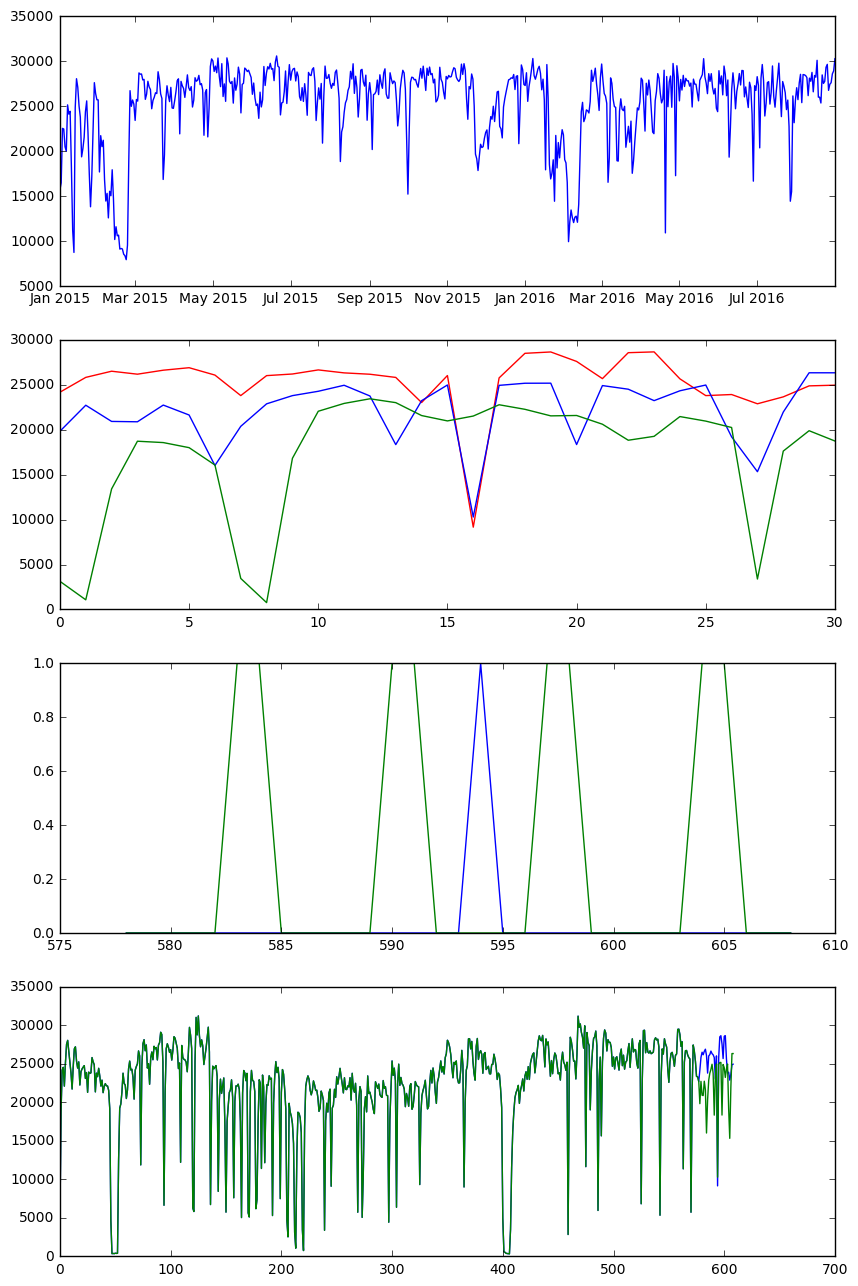

In [214]:
## 743
plt.figure(figsize = [10,16])
plt.subplot(4,1,1)
plt.plot(data_Filled.iloc[742,:])
plt.subplot(4,1,2)
plt.plot(list(dataY1[-31:]),color = 'r')
plt.plot(preds1138_1,color = 'b')
plt.plot(list(dataY1[-31-366:-366]),color = 'g')
plt.subplot(4,1,3)
plt.plot(holiday_Idx[-61:-30])
plt.plot(weekend_Idx[-61:-30])
plt.subplot(4,1,4)
plt.plot(list(dataY1))
plt.plot(list(preds1138_2)+list(preds1138_1))

In [62]:
dataX1 = dataForXGB.iloc[:-30,:]
predDivided = []
for i in range(data_Filled.shape[0]):
    dataY1 = data_Filled.iloc[i,:]
    print(i+1)
    bst,preds743_1,preds743_2 = modelWithHistoryData2(dataX1,dataY1,two_step = False)
    #dTestTemp = xgb.DMatrix(dataX1.iloc[30:,:],dataY1[:-31])
    #temp = bst.predict(dTestTemp)
    predDivided.append(preds743_1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [61]:
dataX1.tail()

,high_T,low_T,dayOfMonth,dayOfYear,dayOfWeek,week,month,year,dateInt,weekend,...,holidayData_chunjie,holidayData_dongzhi,holidayData_duanwu,holidayData_kangri,holidayData_qingming,holidayData_shiyi,holidayData_wd_Shift,holidayData_wuyi,holidayData_yuandan,holidayData_zhongqiu
date,,,,,,,,,,,,,,,,,,,,,
2016-08-27,29,20,27,240,6,34,8,2016,1472256000000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-28,30,19,28,241,7,34,8,2016,1472342400000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-29,30,21,29,242,1,35,8,2016,1472428800000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-30,30,21,30,243,2,35,8,2016,1472515200000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-31,31,22,31,244,3,35,8,2016,1472601600000000000,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
result1 = np.array(predDivided[0][-31:])
for ele in predDivided:
    result1 += np.array(ele[-31:])
result1 -= np.array(predDivided[0][-31:])

In [60]:
pd.Series(result1).to_pickle('Seperated_result.pkl')

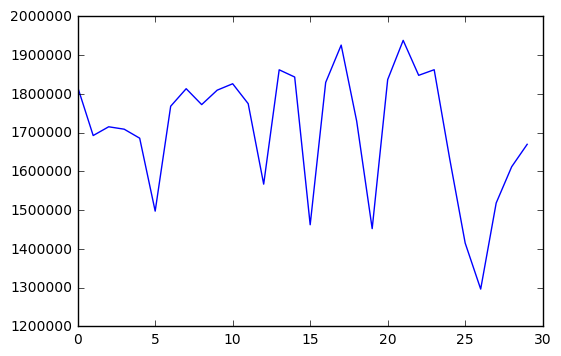

In [57]:
plt.plot(result1)

In [53]:
len(predDivided),len(predDivided[0])

(1454, 579)

## Model2: historical data

In [129]:
def modelWithHistoryData(dataX,dataY):
    seed = 42
    dTrain1 = xgb.DMatrix(dataX.iloc[:-31,:],dataY[:-31])
    dTest1 = xgb.DMatrix(dataX.iloc[-31:,:],dataY[-31:])
    
    num_round = 1000
    evallist1 = [(dTrain1,'train'),(dTest1,'test')]

    param = {'bst:max_depth':12,
             'bst:eta':0.01,
             'subsample':0.8,
             'colsample_bytree':0.7,
             'silent':1,
             'objective':'reg:linear',
             'nthread':6,
             'eval_metric':'rmse',
             'seed':seed}

    plst = param.items()

    bst = xgb.train(plst, dTrain1, num_round, evallist1, 
                    verbose_eval=20, 
                    #obj = logregobj,
                    #feval = rcme,
                early_stopping_rounds=250)
    return bst,bst.predict(dTest1)

In [173]:
#p = [1,2,3,4,5,6,7,8,9,10]
p = [1,2,7]
q = range(1,2)

In [174]:
historicalData_All = data_Filled.sum()
historyData = {}
for i in p:
    historyData['historyData' + str(i)] = list(historicalData_All.shift(i))
historyData = pd.DataFrame(historyData)
historyData.index = historicalData_All.index

# the value a month ago
temp = []
month_Days = [31,28,31,30,31,30,31,31,30,31,30,31]
for i in range(historyData.shape[0]):
    if historyData.index[i].month == 3 and historyData.index[i].year%4 ==0:
        idx = i -29
    else:
        idx = i - month_Days[historyData.index[i].month - 2]
    if idx>=0:
        temp.append(historicalData_All[idx])
    else:
        temp.append(np.float('nan'))
historyData = historyData.join(pd.DataFrame(temp,columns =[ 'historyData_OneMonthAgo'],index =historyData.index ))
historyData.historyData_OneMonthAgo = historyData.historyData_OneMonthAgo.fillna(method = 'ffill')

In [171]:
# the value a year ago
temp = []
month_Days = [31,28,31,30,31,30,31,31,30,31,30,31]
for i in range(historyData.shape[0]):
    if historyData.index[i].month >= 3:
        idx = i -366
    else:
        idx = i - 365
    if idx>=0:
        temp.append(historicalData_All[idx])
    else:
        temp.append(np.float('nan'))
historyData = historyData.join(pd.DataFrame(temp,columns =[ 'historyData_OneYearAgo'],index =historyData.index ))

In [175]:
# high_T
historicalWeather_Data_HighT_All = weather.high_T[:609]
historicalWeather_Data_HighT = {}
for i in q:
    historicalWeather_Data_HighT['weatherData_highT' +str(i)] = list(historicalWeather_Data_HighT_All.shift(i))
historicalWeather_Data_HighT= pd.DataFrame(historicalWeather_Data_HighT)
historicalWeather_Data_HighT.index = historicalWeather_Data_HighT_All.index

#low_T
historicalWeather_Data_LowT_All = weather.low_T[:609]
historicalWeather_Data_LowT = {}
for i in q:
    historicalWeather_Data_LowT['weatherData_lowT' +str(i)] = list(historicalWeather_Data_LowT_All.shift(i))
historicalWeather_Data_LowT= pd.DataFrame(historicalWeather_Data_LowT)
historicalWeather_Data_LowT.index = historicalWeather_Data_LowT_All.index

In [76]:
holidayData_OneHot.head()

,holidayData_0,holidayData_Guijie,holidayData_chunjie,holidayData_dongzhi,holidayData_duanwu,holidayData_kangri,holidayData_qingming,holidayData_shiyi,holidayData_wd_Shift,holidayData_wuyi,holidayData_yuandan,holidayData_zhongqiu
2015-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
# holiday: windows: lower and upper, only applicable for chunjie
## add two new features: days before a holiday, or days after a holiday (有限制，只算到之前7天和之后7天，太长就不考虑了)
## holiday are classified into three sets: 
idx = pd.Series(np.arange(holidayData_OneHot.shape[0]))
idx.index = holidayData_OneHot.index
holidayData_OneHot_expended = holidayData_OneHot.copy()
for i in range(1,holidayData_OneHot.shape[1]):
    temp1= holidayData_OneHot.iloc[:,i].copy()
    temp2= holidayData_OneHot.iloc[:,i].copy()
    idxTemp1 = idx[np.logical_and(temp1 != 0 ,temp1.shift(1) == 0)]
    idxTemp2 = idx[np.logical_and(temp1 != 0 ,temp1.shift(-1) == 0)]
    for idx_Item in idxTemp1:
        try:
            temp1.iloc[idx_Item-7:idx_Item] =(np.arange(7)+1)[::-1]
        except:
            temp1.iloc[:idx_Item] = [3,2,1]
    for idx_Item in idxTemp2:
        temp2.iloc[idx_Item+1:idx_Item+8] =(np.arange(7)+1)
    holidayData_OneHot_expended = holidayData_OneHot_expended.join(temp2,rsuffix = '_daysAfter').join(temp1,rsuffix = '_daysbefore')

In [82]:
lower_window = 7
upper_window = 7
holidayData_expand = []
for i in range(holidayData_OneHot.shape[1]):
    temp1 = holidayData_OneHot.iloc[:,i:i+1]
    if temp1.columns[0] == 'holidayData_chunjie':       
        for j in range(lower_window):
            temp1 = temp1.join(holidayData_OneHot.iloc[:,i].shift(0-j-1),rsuffix = '_-' + str(j+1))
        for j in range(upper_window):
            temp1 = temp1.join(holidayData_OneHot.iloc[:,i].shift(j+1), rsuffix = '_' +str(j+1))
    if not len(holidayData_expand):
        holidayData_expand = temp1
    else:
        holidayData_expand = holidayData_expand.join(temp1)

In [179]:
dataForXGB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2015-01-01 to 2016-09-30
Data columns (total 22 columns):
high_T                  639 non-null int64
low_T                   639 non-null int64
dayOfMonth              639 non-null int32
dayOfYear               639 non-null int32
dayOfWeek               639 non-null int64
week                    639 non-null int32
month                   639 non-null int32
year                    639 non-null int32
dateInt                 639 non-null int64
weekend                 639 non-null bool
holidayData_0           639 non-null float64
holidayData_Guijie      639 non-null float64
holidayData_chunjie     639 non-null float64
holidayData_dongzhi     639 non-null float64
holidayData_duanwu      639 non-null float64
holidayData_kangri      639 non-null float64
holidayData_qingming    639 non-null float64
holidayData_shiyi       639 non-null float64
holidayData_wd_Shift    639 non-null float64
holidayData_wuyi        639 non-null float

In [177]:
dataForXGB2 = dataForXGB.iloc[:,:10].join(historicalWeather_Data_LowT).join(historicalWeather_Data_HighT).join(\
                historyData).join(holidayData_expand)

In [193]:
dataForXGB2 = dataForXGB.iloc[:,:10].join(historicalWeather_Data_LowT).join(historicalWeather_Data_HighT).join(holidayData_OneHot_expended)

In [167]:
dataForXGB4 = dataForXGB.iloc[:,:10].join(historicalWeather_Data_LowT).join(historicalWeather_Data_HighT).join(holidayData_OneHot_expended)

NameError: name 'historicalWeather_Data_LowT' is not defined

In [874]:
dataForXGB2 = dataForXGB.iloc[:,:10].join(holidayData_expand)

### model2_1: historyData: 1,2,7,a month ago

In [194]:
dataForXGB2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2015-01-01 to 2016-09-30
Data columns (total 46 columns):
high_T                             639 non-null int64
low_T                              639 non-null int64
dayOfMonth                         639 non-null int32
dayOfYear                          639 non-null int32
dayOfWeek                          639 non-null int64
week                               639 non-null int32
month                              639 non-null int32
year                               639 non-null int32
dateInt                            639 non-null int64
weekend                            639 non-null bool
weatherData_lowT1                  608 non-null float64
weatherData_highT1                 608 non-null float64
holidayData_0                      639 non-null float64
holidayData_Guijie                 639 non-null float64
holidayData_chunjie                639 non-null float64
holidayData_dongzhi                639 non-null float64
h

In [196]:
dataY2.shape

(578,)

In [199]:
data_Filled.sum().head()

record_date
2015-01-01     868959
2015-01-02    1061059
2015-01-03    1368263
2015-01-04    1580376
2015-01-05    1676958
dtype: int64

In [200]:
dataForXGB2_1 = dataForXGB2.iloc[:-30,:]
dataY2 = data_Filled.sum()
bst2,preds2_1 = modelWithHistoryData(dataForXGB2_1,dataY2)

[0]	train-rmse:1.0624e+06	test-rmse:1.34973e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:47876.9	test-rmse:206230
[40]	train-rmse:27918.6	test-rmse:209501
[60]	train-rmse:17307.8	test-rmse:214071
[80]	train-rmse:11091.5	test-rmse:214610
[100]	train-rmse:7730.24	test-rmse:213200
[120]	train-rmse:5045.45	test-rmse:213601
[140]	train-rmse:3444.07	test-rmse:214029
[160]	train-rmse:2297.98	test-rmse:214994
[180]	train-rmse:1673.97	test-rmse:215159
[200]	train-rmse:1146.18	test-rmse:214911
[220]	train-rmse:815.048	test-rmse:214950
[240]	train-rmse:611.926	test-rmse:215097
[260]	train-rmse:438.37	test-rmse:214934
Stopping. Best iteration:
[23]	train-rmse:44508.3	test-rmse:203789



## One-by-one prediction
#since we must predict the daily values in the next month, we have to implement a one-by-one prediction


In [201]:
### without reconstructing model
prediction2_OneByOne_NoRE = []
dataForXGB_OBO = dataForXGB2_1.copy()

dataY = dataY2.copy() # endTime: 8-31

for i in range(31):
    if i == 30:
        x_Vec = dataForXGB_OBO.iloc[-31+i:,:]
    else:
        x_Vec = dataForXGB_OBO.iloc[-31+i:-30+i,:]
    
    for j in p:  #用一个月前的历史数据有好处，不用一个一个的预测！
        if j<= len(prediction2_OneByOne_NoRE):
            setattr(x_Vec,'historyData'+str(j),prediction2_OneByOne_NoRE[0-j] )    
    dTest_Vec = xgb.DMatrix(x_Vec,data_Filled.sum()[-31:-30])
    prediction2_OneByOne_NoRE.append(bst2.predict(dTest_Vec)[0])

### model2_2: historyData: a month ago

In [461]:
dataForXGB2_2 = dataForXGB2.drop(labels = ['historyData1','historyData2','historyData7','weatherData_highT0','weatherData_lowT0'],axis = 1)

In [856]:
dataForXGB2_2 = dataForXGB2.drop(labels = ['weatherData_highT1','weatherData_lowT1'],axis = 1)

In [857]:
dataForXGB2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578 entries, 2015-02-01 to 2016-08-31
Data columns (total 38 columns):
high_T                     578 non-null int64
low_T                      578 non-null int64
dayOfMonth                 578 non-null int32
dayOfYear                  578 non-null int32
dayOfWeek                  578 non-null int64
week                       578 non-null int32
month                      578 non-null int32
year                       578 non-null int32
dateInt                    578 non-null int64
weekend                    578 non-null bool
weatherData_lowT1          578 non-null float64
weatherData_highT1         578 non-null float64
historyData1               578 non-null float64
historyData2               578 non-null float64
historyData7               578 non-null float64
historyData_OneMonthAgo    578 non-null float64
holidayData_0              578 non-null float64
holidayData_Guijie         578 non-null float64
holidayData_chunjie        578 no

In [707]:
dataX = dataForXGB2_2.iloc[31:-30,:]
dataY = data_Filled.sum()[31:]
bst2_2,preds2_2 = modelWithHistoryData(dataX,dataY)

[0]	train-rmse:1.19865e+06	test-rmse:1.576e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:31471.8	test-rmse:137416
[40]	train-rmse:15643.8	test-rmse:132516
[60]	train-rmse:7910.76	test-rmse:133015
[80]	train-rmse:3992.2	test-rmse:133057
[100]	train-rmse:2061.88	test-rmse:132414
[120]	train-rmse:1158.32	test-rmse:132577
[140]	train-rmse:614.762	test-rmse:132429
[160]	train-rmse:290.99	test-rmse:132437
[180]	train-rmse:131.73	test-rmse:132447
[200]	train-rmse:70.1899	test-rmse:132460
[220]	train-rmse:37.1149	test-rmse:132464
[240]	train-rmse:18.4665	test-rmse:132462
[260]	train-rmse:10.3707	test-rmse:132471
[280]	train-rmse:5.38447	test-rmse:132472
Stopping. Best iteration:
[34]	train-rmse:19498.4	test-rmse:129788



In [708]:
featureImp = bst2_2.get_fscore()
newList = sorted(featureImp.items(), key = lambda k:k[1],reverse = True)

In [709]:
newList

[('high_T', 1198),
 ('historyData7', 1061),
 ('historyData_OneMonthAgo', 986),
 ('historyData1', 979),
 ('dayOfMonth', 922),
 ('historyData2', 917),
 ('low_T', 821),
 ('dayOfYear', 800),
 ('dateInt', 659),
 ('dayOfWeek', 401),
 ('week', 204),
 ('year', 36),
 ('holidayData_0_-2', 29),
 ('holidayData_0', 28),
 ('holidayData_0_2', 24),
 ('holidayData_qingming_1', 22),
 ('holidayData_0_-1', 19),
 ('holidayData_qingming', 18),
 ('holidayData_0_1', 16),
 ('month', 15),
 ('holidayData_duanwu', 14),
 ('holidayData_wd_Shift_2', 12),
 ('holidayData_wd_Shift_-2', 12),
 ('holidayData_wd_Shift_-1', 10),
 ('holidayData_wd_Shift', 10),
 ('holidayData_duanwu_-2', 8),
 ('holidayData_qingming_-1', 8),
 ('holidayData_qingming_2', 7),
 ('holidayData_shiyi_2', 7),
 ('holidayData_duanwu_-1', 7),
 ('holidayData_zhongqiu_-2', 6),
 ('holidayData_wd_Shift_1', 6),
 ('holidayData_wuyi_-1', 6),
 ('holidayData_zhongqiu', 6),
 ('holidayData_shiyi', 6),
 ('holidayData_shiyi_1', 5),
 ('holidayData_zhongqiu_1', 5),
 ('

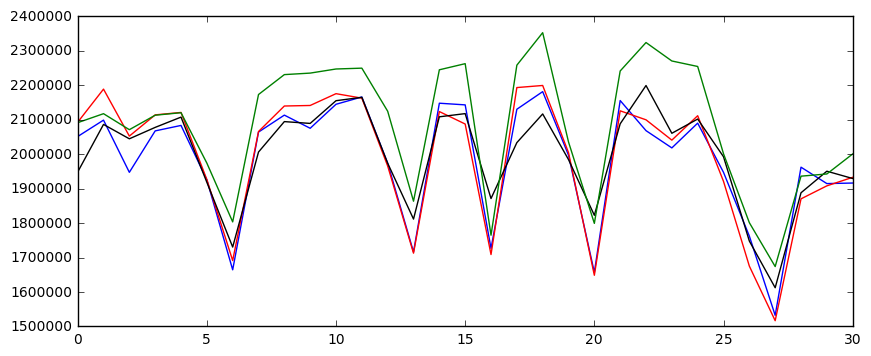

In [877]:
##
plt.figure(figsize = [10,4])
plt.plot(np.arange(31),preds2_1,'b')
#plt.plot(np.arange(31),preds2_2,'c')
plt.plot(np.arange(31),preds1_1,'r')
plt.plot(np.arange(31),prediction2_OneByOne_NoRE,'k')
plt.plot(np.arange(31),data_Filled.sum()[578:609],'g');

In [878]:
print('RSME of model1:  '+str(rsme_F(preds1_1,data_Filled.sum()[578:609])))
# # 因为预测一个月的时候并不知道1，2，7的数值
print('RSME of model2:  '+str(rsme_F(preds2_1,data_Filled.sum()[578:609])))
print('RSME of model3:  '+str(rsme_F(prediction2_OneByOne_NoRE,data_Filled.sum()[578:609])))
#
print('RSME of model3:  '+str(rsme_F(preds2_2,data_Filled.sum()[578:609])))


RSME of model1:  0.00298849234016
RSME of model2:  0.00317970683426
RSME of model3:  0.00282907021119
RSME of model3:  0.00357678971426


## divide the origin Y data into two part: 
    values at changePoints are extracted from original set, and all changePoint are filled by interpolattion

In [897]:
dataY = data_Filled.sum()

In [928]:
## windows for chunjie
holiday_Idx[41:62] =True
holiday_Idx[395:417] =True 

weekendOrHoliday = weekend_Idx +0+ holiday_Idx 
weekendOrHoliday = weekendOrHoliday[:-30]
weekendOrHoliday.index = dataY.index
#
set1_index = weekendOrHoliday > 0
#
dataY_CP = dataY>0 -1
dataY_CP[set1_index] = dataY[set1_index]

dataY_Rest = dataY-dataY_CP
dataY_Rest[dataY_Rest == 0] = np.float('nan')
dataY_Rest = dataY_Rest.fillna(method = 'ffill')

In [921]:
dataForXGB4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2015-01-01 to 2016-09-30
Data columns (total 16 columns):
high_T                     639 non-null int64
low_T                      639 non-null int64
dayOfMonth                 639 non-null int32
dayOfYear                  639 non-null int32
dayOfWeek                  639 non-null int64
week                       639 non-null int32
month                      639 non-null int32
year                       639 non-null int32
dateInt                    639 non-null int64
weekend                    639 non-null bool
weatherData_lowT1          608 non-null float64
weatherData_highT1         608 non-null float64
historyData1               608 non-null float64
historyData2               607 non-null float64
historyData7               602 non-null float64
historyData_OneMonthAgo    578 non-null float64
dtypes: bool(1), float64(6), int32(5), int64(4)
memory usage: 68.0 KB


In [924]:
dataForXGB4 = dataForXGB4.iloc[31:-30,:]
dataY4 = dataY_Rest[31:]
bst4,preds4_1 = modelWithHistoryData(dataForXGB4,dataY4)

[0]	train-rmse:1.28e+06	test-rmse:1.63622e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:23579.5	test-rmse:140161
[40]	train-rmse:8412.92	test-rmse:132820
[60]	train-rmse:3811.03	test-rmse:132452
[80]	train-rmse:1760.42	test-rmse:131474
[100]	train-rmse:900.049	test-rmse:131354
[120]	train-rmse:467.517	test-rmse:131336
[140]	train-rmse:216.731	test-rmse:131326
[160]	train-rmse:107.728	test-rmse:131283
[180]	train-rmse:53.5692	test-rmse:131290
[200]	train-rmse:28.4383	test-rmse:131285
[220]	train-rmse:14.3995	test-rmse:131281
[240]	train-rmse:7.21369	test-rmse:131280
[260]	train-rmse:3.39737	test-rmse:131280
[280]	train-rmse:1.8721	test-rmse:131280
[300]	train-rmse:0.869301	test-rmse:131280
[320]	train-rmse:0.447354	test-rmse:131280
Stopping. Best iteration:
[83]	train-rmse:1649.03	test-rmse:131237



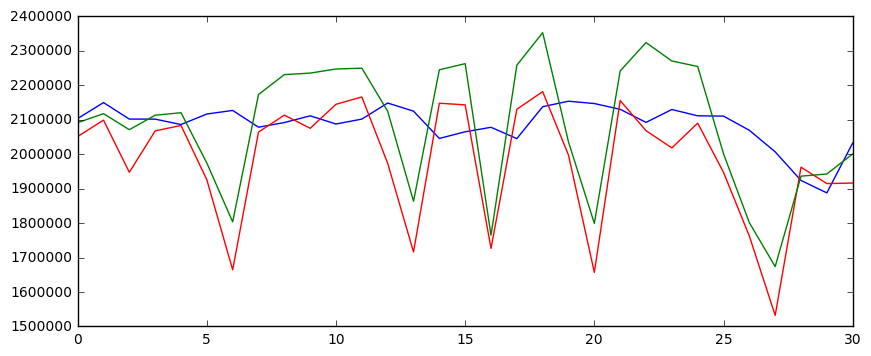

In [926]:
##
plt.figure(figsize = [10,4])
plt.plot(np.arange(31),preds4_1,'b')
plt.plot(np.arange(31),preds2_1,'r')
plt.plot(np.arange(31),data_Filled.sum()[578:609],'g');

In [758]:
dataY_CP.head()

2015-01-01    1168800.0
2015-01-02          1.0
2015-01-03          1.0
2015-01-04          1.0
2015-01-05          1.0
dtype: float64

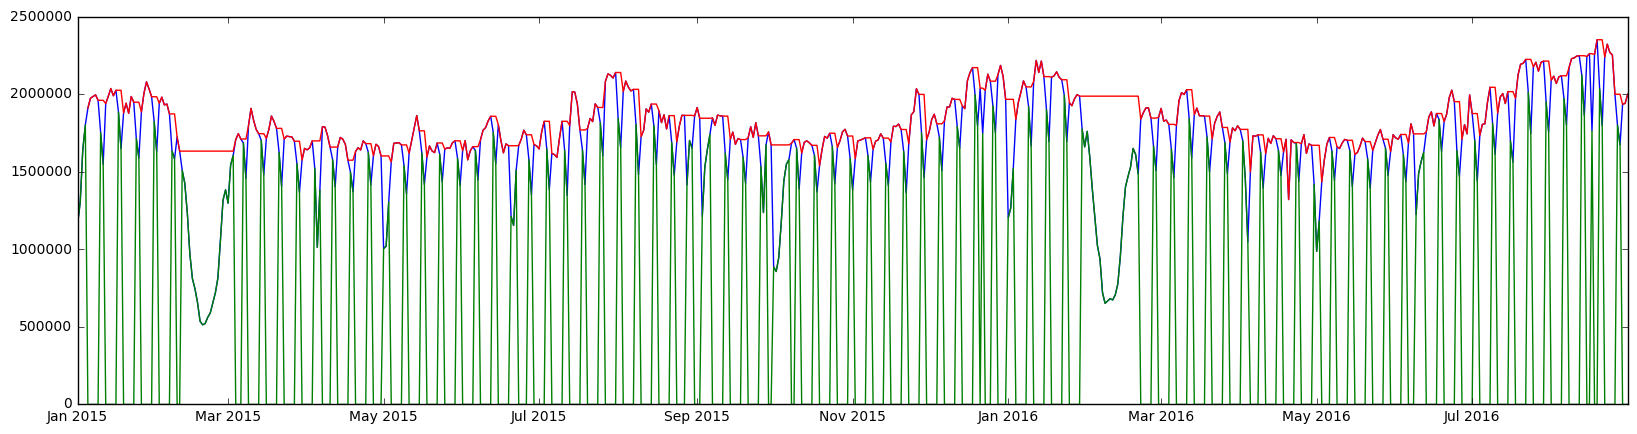

In [911]:
plt.figure(figsize = [20,5])
plt.plot(dataY)
plt.plot(dataY_CP)
plt.plot(dataY_Rest)

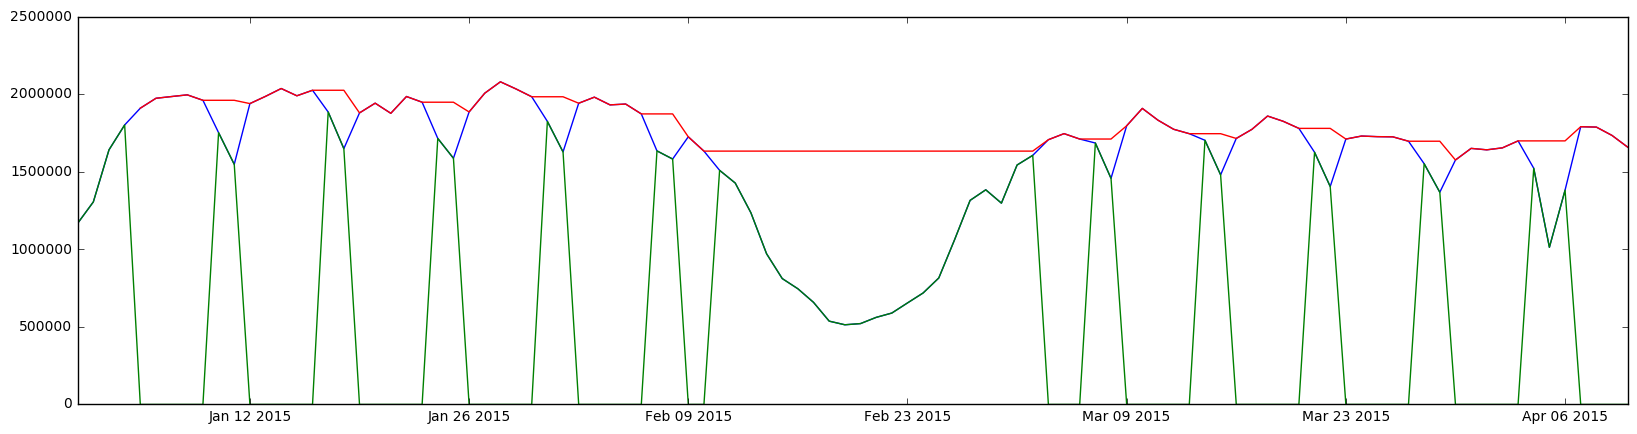

In [915]:
plt.figure(figsize = [20,5])
plt.plot(dataY[0:100])
plt.plot(dataY_CP[0:100])
plt.plot(dataY_Rest[0:100])

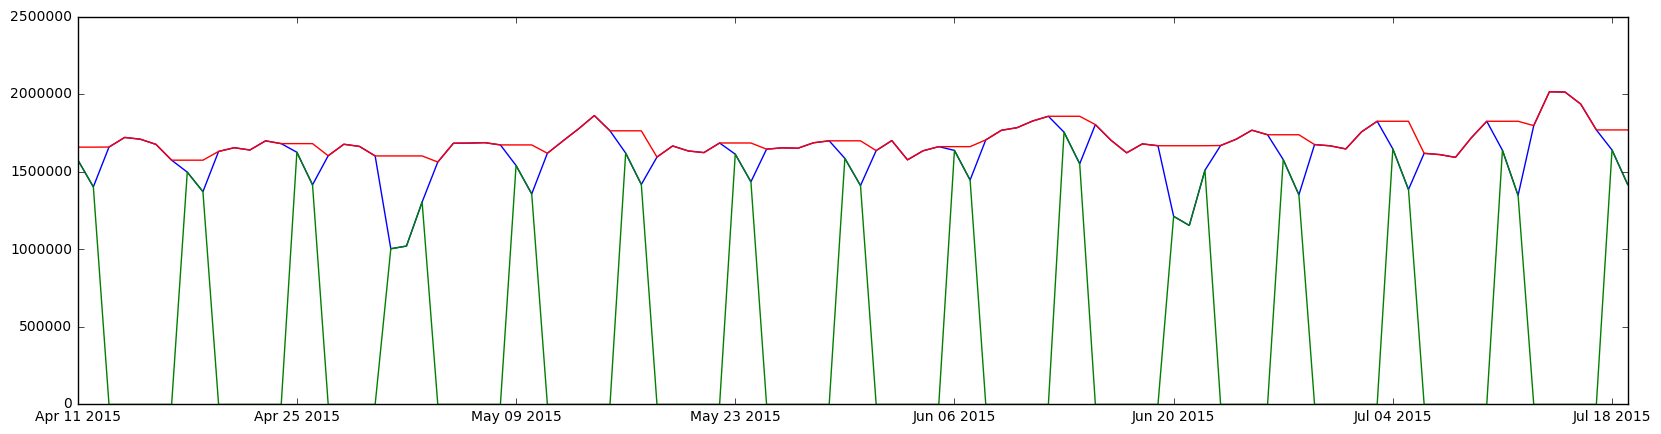

In [913]:
plt.figure(figsize = [20,5])
plt.plot(dataY[100:200])
plt.plot(dataY_CP[100:200])
plt.plot(dataY_Rest[100:200])

### result:

In [455]:
dTrain1 = xgb.DMatrix(dataX.iloc[:-31,:],dataY[:-31])
dTest1 = xgb.DMatrix(dataX.iloc[-31:,:],dataY[-31:])

num_round = 1000
evallist1 = [(dTrain1,'train'),(dTest1,'test')]

param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'eval_metric':'rmse',
         'seed':seed}

plst = param.items()

bst = xgb.train(plst, dTrain1, num_round, evallist1, 
                verbose_eval=20, 
                #obj = logregobj,
                #feval = rcme,
                early_stopping_rounds=250)


[0]	train-rmse:1.19886e+06	test-rmse:1.57477e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:35113	test-rmse:133266
[40]	train-rmse:17250.7	test-rmse:138008
[60]	train-rmse:9453.47	test-rmse:135036
[80]	train-rmse:5454.21	test-rmse:137338
[100]	train-rmse:3099.89	test-rmse:138239
[120]	train-rmse:1792.23	test-rmse:136749
[140]	train-rmse:1029.18	test-rmse:136849
[160]	train-rmse:596.371	test-rmse:136469
[180]	train-rmse:358.007	test-rmse:136439
[200]	train-rmse:220.768	test-rmse:136414
[220]	train-rmse:121.718	test-rmse:136480
[240]	train-rmse:67.737	test-rmse:136513
[260]	train-rmse:41.4361	test-rmse:136518
Stopping. Best iteration:
[20]	train-rmse:35113	test-rmse:133266



In [456]:
preds2_2= bst.predict(dTest1)

In [406]:
prediction_Re2 = bst.predict(dTest1)

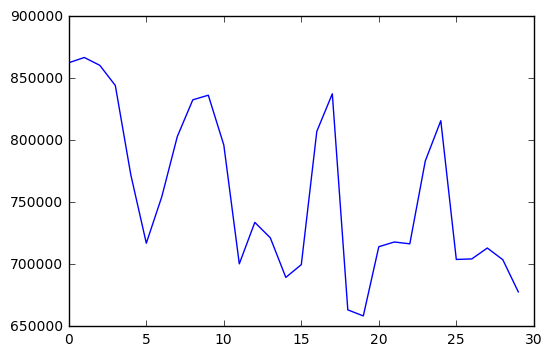

In [407]:
plt.plot(prediction_Re2)

In [378]:
featureImp = bst2.get_fscore()
newList = sorted(featureImp.items(), key = lambda k:k[1],reverse = True)

In [323]:
dataForXGB2_2 = dataForXGB2.drop(labels = ['historyData1','historyData2','historyData7','weatherData_lowT1','weatherData_lowT2',
                                          'weatherData_highT1','weatherData_highT2','weatherData_highT0','weatherData_lowT0'],axis = 1)

In [348]:
dataForXGB2_2 = dataForXGB2.drop(labels = ['historyData1','historyData2','historyData7','weatherData_highT0','weatherData_lowT0'],axis = 1)

In [349]:
dataForXGB2_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578 entries, 2015-02-01 to 2016-08-31
Data columns (total 75 columns):
high_T                     578 non-null int64
low_T                      578 non-null int64
dayOfMonth                 578 non-null int32
dayOfYear                  578 non-null int32
dayOfWeek                  578 non-null int64
week                       578 non-null int32
month                      578 non-null int32
year                       578 non-null int32
dateInt                    578 non-null int64
weatherData_lowT1          578 non-null float64
weatherData_lowT2          578 non-null float64
weatherData_highT1         578 non-null float64
weatherData_highT2         578 non-null float64
historyData_OneMonthAgo    578 non-null float64
historyData_OneYearAgo     244 non-null float64
holidayData_0              578 non-null float64
holidayData_0_-1           578 non-null float64
holidayData_0_-2           578 non-null float64
holidayData_0_1            578

In [353]:
dataForXGB2_2.shape

(578, 75)

In [334]:
dataY2.shape

(578,)

In [335]:
dataForXGB2_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578 entries, 2015-02-01 to 2016-08-31
Data columns (total 27 columns):
high_T                     578 non-null int64
low_T                      578 non-null int64
dayOfMonth                 578 non-null int32
dayOfYear                  578 non-null int32
dayOfWeek                  578 non-null int64
week                       578 non-null int32
month                      578 non-null int32
year                       578 non-null int32
dateInt                    578 non-null int64
weatherData_lowT1          578 non-null float64
weatherData_lowT2          578 non-null float64
weatherData_highT1         578 non-null float64
weatherData_highT2         578 non-null float64
historyData_OneMonthAgo    578 non-null float64
historyData_OneYearAgo     244 non-null float64
holidayData_0              578 non-null float64
holidayData_Guijie         578 non-null float64
holidayData_chunjie        578 non-null float64
holidayData_dongzhi        578

In [350]:
bst2_2,preds2_2 = modelWithHistoryData(dataForXGB2_2.iloc[365:,:],dataY2.iloc[365:])

[0]	train-rmse:1.20424e+06	test-rmse:1.57666e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:18106.7	test-rmse:137753
[40]	train-rmse:4030.12	test-rmse:133558
[60]	train-rmse:904.588	test-rmse:132249
[80]	train-rmse:210.573	test-rmse:132106
[100]	train-rmse:57.2575	test-rmse:132176
[120]	train-rmse:16.7389	test-rmse:132191
[140]	train-rmse:4.53681	test-rmse:132188
[160]	train-rmse:1.08253	test-rmse:132187
[180]	train-rmse:0.315201	test-rmse:132188
[200]	train-rmse:0.168255	test-rmse:132188
[220]	train-rmse:0.161883	test-rmse:132187
[240]	train-rmse:0.159681	test-rmse:132187
[260]	train-rmse:0.157652	test-rmse:132187
[280]	train-rmse:0.158669	test-rmse:132187
[300]	train-rmse:0.152672	test-rmse:132187
[320]	train-rmse:0.154974	test-rmse:132187
Stopping. Best iteration:
[80]	train-rmse:210.573	test-rmse:132106



In [137]:
## One-by-one prediction
since we must predict the daily values in the next month, we have to implement a one-by-one prediction

### without reconstructing model

prediction2_OneByOne_NoRE = []
dataForXGB3 = dataForXGB2_1.copy()

dataY = dataY2.copy() # endTime: 8-31

for i in range(31):
    if i == 30:
        x_Vec = dataForXGB3.iloc[-31+i:,:]
    else:
        x_Vec = dataForXGB3.iloc[-31+i:-30+i,:]
    
    for j in p:  #用一个月前的历史数据有好处，不用一个一个的预测！
        if j<= len(prediction2_OneByOne_NoRE):
            setattr(x_Vec,'historyData'+str(j),prediction2_OneByOne_NoRE[0-j] )    
    dTest_Vec = xgb.DMatrix(x_Vec,data_Filled.sum()[-31:-30])
    prediction2_OneByOne_NoRE.append(bst2.predict(dTest_Vec)[0])

D:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### reconstructing model

In [158]:
prediction2_OneByOne = []
dataForXGB3 = dataForXGB2.copy()

dataY = dataY2.copy() # endTime: 8-31

for i in range(31):
    # reconstruct model in each turn
    bst3 = constructModel(dataForXGB3.iloc[:-31+i,:],dataY[:-31+i])
                         
    if i == 30:
        x_Vec = dataForXGB3.iloc[-31+i:,:]
    else:
        x_Vec = dataForXGB3.iloc[-31+i:-30+i,:]

    dTest_Vec = xgb.DMatrix(x_Vec,dataY[-31:-30]) # Y is a random value
    prediction2_OneByOne.append(bst3.predict(dTest_Vec)[0])
    dataY.iloc[-31+i:-30+i] = prediction2_OneByOne[-1]
    
    # update dataForXGB3 
    x_Vec = dataForXGB3.iloc[-30+i:-29+i,:]
    for j in p:
        if j<= len(prediction2_OneByOne):
            setattr(x_Vec,'historyData'+str(j),prediction2_OneByOne[0-j] )    
    dataForXGB3.iloc[-30+i:-29+i,:] = x_Vec

[0]	train-rmse:1.18737e+06	test-rmse:1.43709e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:29232.3	test-rmse:102993
[40]	train-rmse:10278.8	test-rmse:103305
[60]	train-rmse:5318.88	test-rmse:102296
[80]	train-rmse:2428.96	test-rmse:102248
[100]	train-rmse:1189.86	test-rmse:102186
[120]	train-rmse:609.036	test-rmse:101995
[140]	train-rmse:269.749	test-rmse:102032
[160]	train-rmse:127.317	test-rmse:101994
[180]	train-rmse:66.5387	test-rmse:101992
[200]	train-rmse:34.432	test-rmse:102008
[220]	train-rmse:16.5631	test-rmse:102019
[240]	train-rmse:8.12716	test-rmse:102023
[260]	train-rmse:4.05776	test-rmse:102022
Stopping. Best iteration:
[22]	train-rmse:25969.6	test-rmse:101051

22
[0]	train-rmse:1.18741e+06	test-rmse:1.44626e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[2

D:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


[80]	train-rmse:3093	test-rmse:92361.6
[100]	train-rmse:1504.76	test-rmse:92352.9
[120]	train-rmse:715.235	test-rmse:92285
[140]	train-rmse:352.77	test-rmse:92355
[160]	train-rmse:182.322	test-rmse:92373.1
[180]	train-rmse:91.1768	test-rmse:92357.9
[200]	train-rmse:46.3434	test-rmse:92355.5
[220]	train-rmse:20.9734	test-rmse:92356.7
[240]	train-rmse:9.74921	test-rmse:92357.2
[260]	train-rmse:4.84803	test-rmse:92357.6
Stopping. Best iteration:
[27]	train-rmse:23316.9	test-rmse:89889.2

27
[0]	train-rmse:1.18754e+06	test-rmse:1.45177e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:34177.4	test-rmse:93109.2
[40]	train-rmse:13851.8	test-rmse:86625.5
[60]	train-rmse:6876.71	test-rmse:88715.7
[80]	train-rmse:3124.37	test-rmse:89494.3
[100]	train-rmse:1507.18	test-rmse:89685.9
[120]	train-rmse:786.141	test-rmse:89775.1
[140]	train-rmse:326.432	test-rmse:89966.6
[160]	train-rmse:

In [224]:
dataY = data_Filled.sum()

In [233]:
dataLastY = dataY[dataY.index[0]+datetime.timedelta(212):dataY.index[0]+datetime.timedelta(242)]

In [234]:
dataLastY.shape

(31,)

NameError: name 'dataLastY' is not defined

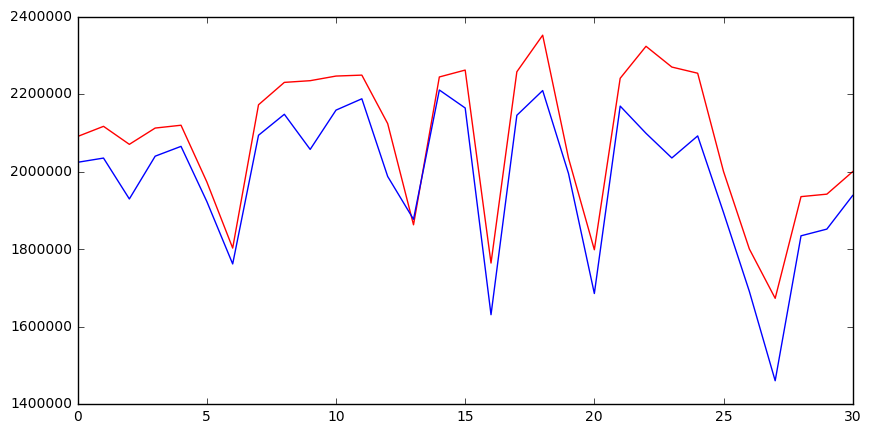

In [43]:
##
plt.figure(figsize = [10,5])
plt.plot(np.arange(31),data_Filled.sum()[578:609],color = 'r')
plt.plot(np.arange(31),prediction1_1,color = 'b')
plt.plot(np.arange(31),dataLastY,color = 'c')
#plt.plot(np.arange(31),prediction2,color = 'g')
#plt.plot(np.arange(31),prediction2_OneByOne,color = 'y')
#plt.plot(np.arange(31),prediction2_OneByOne_NoRE,color = 'k')

In [207]:
# Why do i use R2 ar evaluation metrics?
## Because the results of R2_Score is similar to that of the online evalution function.,也不是。还是差很多
print('R2 of model1:  '+str(met.r2_score(prediction,data_Filled.sum()[578:609])))
print('R2 of model2:  '+str(met.r2_score(prediction2,data_Filled.sum()[578:609])))
print('R2 of model3:  '+str(met.r2_score(prediction2_OneByOne,data_Filled.sum()[578:609])))
print('R2 of model3:  '+str(met.r2_score(prediction2_OneByOne_NoRE,data_Filled.sum()[578:609])))

R2 of model1:  0.596418795964
R2 of model2:  0.397900604861
R2 of model3:  -2.23174367675
R2 of model3:  0.0815343007372


In [212]:
print('RSME of model1:  '+str(rsme_F(prediction,data_Filled.sum()[578:609])))
print('RSME of model2:  '+str(rsme_F(prediction2,data_Filled.sum()[578:609])))
print('RSME of model3:  '+str(rsme_F(prediction2_OneByOne,data_Filled.sum()[578:609])))
print('RSME of model3:  '+str(rsme_F(prediction2_OneByOne_NoRE,data_Filled.sum()[578:609])))

RSME of model1:  0.00317705140218
RSME of model2:  0.00278502704616
RSME of model3:  0.00908284867255
RSME of model3:  0.00355098401518


## feature engineering
* historical data：0~60
    - Result: 1,2, 7, the same day in the last month
* historical weather data: 0~60
* holiday: upper, and lower， 0~7


### historical data

In [740]:
#p = [1,2,3,4,5,6,7,8,9,10]
p = [1,2,7]
q = range(1,3)

In [308]:
historicalData_All = data_Filled.sum()
historyData = {}
for i in p:
    historyData['historyData' + str(i)] = list(historicalData_All.shift(i))
historyData = pd.DataFrame(historyData)
historyData.index = historicalData_All.index

# the value a month ago
temp = []
month_Days = [31,28,31,30,31,30,31,31,30,31,30,31]
for i in range(historyData.shape[0]):
    if historyData.index[i].month == 3 and historyData.index[i].year%4 ==0:
        idx = i -29
    else:
        idx = i - month_Days[historyData.index[i].month - 2]
    if idx>=0:
        temp.append(historicalData_All[idx])
    else:
        temp.append(np.float('nan'))
historyData = historyData.join(pd.DataFrame(temp,columns =[ 'historyData_OneMonthAgo'],index =historyData.index ))

# the value a year ago
temp = []
month_Days = [31,28,31,30,31,30,31,31,30,31,30,31]
for i in range(historyData.shape[0]):
    if historyData.index[i].month >= 3:
        idx = i -366
    else:
        idx = i - 365
    if idx>=0:
        temp.append(historicalData_All[idx])
    else:
        temp.append(np.float('nan'))
historyData = historyData.join(pd.DataFrame(temp,columns =[ 'historyData_OneYearAgo'],index =historyData.index ))

In [309]:
historyData.head()

,historyData1,historyData2,historyData7,historyData_OneMonthAgo,historyData_OneYearAgo
2015-01-01,NaN,NaN,NaN,NaN,NaN
2015-01-02,1168800.0,NaN,NaN,NaN,NaN
2015-01-03,1306631.0,1168800.0,NaN,NaN,NaN
2015-01-04,1642575.0,1306631.0,NaN,NaN,NaN
2015-01-05,1803064.0,1642575.0,NaN,NaN,NaN


In [310]:
dataForXGB4_1 = dataForXGB.iloc[:-30,:].join(historyData).iloc[365:,:]
dataY = data_Filled.sum()[365:]

In [311]:
dataForXGB4_1.s

(244, 26)

In [313]:
bst_Test1 = constructModel_FE(dataForXGB4_1,dataY)

[0]	train-rmse:1.23522e+06	test-rmse:1.57588e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:24465.8	test-rmse:120191
[40]	train-rmse:5683.92	test-rmse:117912
[60]	train-rmse:1408.17	test-rmse:116930
[80]	train-rmse:401.384	test-rmse:116759
[100]	train-rmse:96.8353	test-rmse:116772
[120]	train-rmse:31.8263	test-rmse:116770
[140]	train-rmse:8.46584	test-rmse:116767
[160]	train-rmse:2.81318	test-rmse:116766
[180]	train-rmse:0.819523	test-rmse:116766
[200]	train-rmse:0.240732	test-rmse:116766
[220]	train-rmse:0.155057	test-rmse:116766
[240]	train-rmse:0.155234	test-rmse:116766
[260]	train-rmse:0.154998	test-rmse:116766
[280]	train-rmse:0.15177	test-rmse:116766
[300]	train-rmse:0.150861	test-rmse:116766
[320]	train-rmse:0.152192	test-rmse:116766
Stopping. Best iteration:
[76]	train-rmse:503.891	test-rmse:116741



In [314]:
featureImp = bst_Test1.get_fscore()
newList = sorted(featureImp.items(), key = lambda k:k[1],reverse = True)

In [315]:
newList

[('high_T', 1120),
 ('dayOfMonth', 831),
 ('historyData7', 821),
 ('historyData2', 804),
 ('historyData_OneMonthAgo', 797),
 ('historyData1', 787),
 ('low_T', 698),
 ('historyData_OneYearAgo', 619),
 ('dayOfYear', 615),
 ('dayOfWeek', 407),
 ('week', 124),
 ('dateInt', 120),
 ('holidayData_qingming', 37),
 ('holidayData_0', 28),
 ('holidayData_duanwu', 13),
 ('holidayData_wuyi', 11),
 ('holidayData_chunjie', 10),
 ('holidayData_wd_Shift', 9),
 ('month', 8)]

In [650]:
dataForXGB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2015-01-01 to 2016-09-30
Data columns (total 21 columns):
high_T                  639 non-null int64
low_T                   639 non-null int64
dayOfMonth              639 non-null int32
dayOfYear               639 non-null int32
dayOfWeek               639 non-null int64
week                    639 non-null int32
month                   639 non-null int32
year                    639 non-null int32
dateInt                 639 non-null int64
holidayData_0           639 non-null float64
holidayData_Guijie      639 non-null float64
holidayData_chunjie     639 non-null float64
holidayData_dongzhi     639 non-null float64
holidayData_duanwu      639 non-null float64
holidayData_kangri      639 non-null float64
holidayData_qingming    639 non-null float64
holidayData_shiyi       639 non-null float64
holidayData_wd_Shift    639 non-null float64
holidayData_wuyi        639 non-null float64
holidayData_yuandan     639 non-null fl

In [649]:
dataForXGB2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2015-01-01 to 2016-09-30
Data columns (total 78 columns):
high_T                     639 non-null int64
low_T                      639 non-null int64
dayOfMonth                 639 non-null int32
dayOfYear                  639 non-null int32
dayOfWeek                  639 non-null int64
week                       639 non-null int32
month                      639 non-null int32
year                       639 non-null int32
dateInt                    639 non-null int64
weatherData_lowT1          608 non-null float64
weatherData_lowT2          607 non-null float64
weatherData_highT1         608 non-null float64
weatherData_highT2         607 non-null float64
historyData1               608 non-null float64
historyData2               607 non-null float64
historyData7               602 non-null float64
historyData_OneMonthAgo    578 non-null float64
historyData_OneYearAgo     244 non-null float64
holidayData_0              639

In [651]:
dataForXGB_test1 = dataForXGB.join(dataForXGB2.historyData1)

In [655]:
bst,preds4_1 = modelWithHistoryData(dataForXGB_test1,dataY1,weight = np.array(changePoints)*(0)+1)

[0]	train-rmse:1.20455e+06	test-rmse:1.53573e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:36657.9	test-rmse:152273
[40]	train-rmse:19965.3	test-rmse:140849
[60]	train-rmse:11162.3	test-rmse:136097
[80]	train-rmse:6261.18	test-rmse:135569
[100]	train-rmse:3891.38	test-rmse:132657
[120]	train-rmse:2554.8	test-rmse:132740
[140]	train-rmse:1544.35	test-rmse:132486
[160]	train-rmse:955.502	test-rmse:132426
[180]	train-rmse:619.881	test-rmse:132207
[200]	train-rmse:403.668	test-rmse:132246
[220]	train-rmse:237.628	test-rmse:132129
[240]	train-rmse:158.717	test-rmse:132170
[260]	train-rmse:99.7489	test-rmse:132161
[280]	train-rmse:62.2743	test-rmse:132179
[300]	train-rmse:40.1621	test-rmse:132181
[320]	train-rmse:26.046	test-rmse:132185
[340]	train-rmse:16.9066	test-rmse:132180
[360]	train-rmse:10.9322	test-rmse:132178
[380]	train-rmse:7.64822	test-rmse:132178
[400]	train-rms

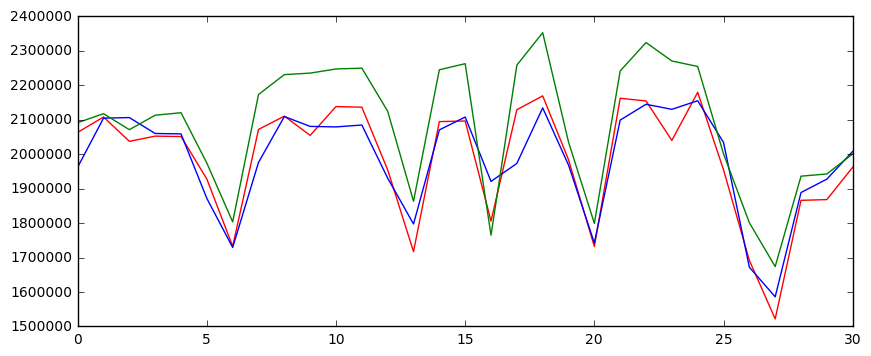

In [657]:
##
plt.figure(figsize = [10,4])
plt.plot(np.arange(31),preds1_1,'r')
plt.plot(np.arange(31),preds4_1,'b')
plt.plot(np.arange(31),data_Filled.sum()[578:609],'g');

In [656]:
print('RSME of model1:  '+str(rsme_F(preds1_1,data_Filled.sum()[578:609])))
print('RSME of model3:  '+str(rsme_F(preds4_1,data_Filled.sum()[578:609])))

RSME of model1:  0.00287185272754
RSME of model3:  0.00375479460028


## historical weather data

In [199]:
q = range(1,30)

In [200]:
# high_T
historicalWeather_Data_HighT_All = weather.high_T[:609]
historicalWeather_Data_HighT = {}
for i in q:
    historicalWeather_Data_HighT['weatherData_highT' +str(i)] = list(historicalWeather_Data_HighT_All.shift(i))
historicalWeather_Data_HighT= pd.DataFrame(historicalWeather_Data_HighT)
historicalWeather_Data_HighT.index = historicalWeather_Data_HighT_All.index

#low_T
historicalWeather_Data_LowT_All = weather.low_T[:609]
historicalWeather_Data_LowT = {}
for i in q:
    historicalWeather_Data_LowT['weatherData_lowT' +str(i)] = list(historicalWeather_Data_LowT_All.shift(i))
historicalWeather_Data_LowT= pd.DataFrame(historicalWeather_Data_LowT)
historicalWeather_Data_LowT.index = historicalWeather_Data_LowT_All.index

In [201]:
dataForXGB4_2 = dataForXGB2.drop(labels = ['weatherData_highT1','weatherData_highT2','weatherData_lowT1','weatherData_lowT2'],axis = 1)

In [202]:
dataForXGB4_2 = dataForXGB4_2.join(historicalWeather_Data_HighT).join(historicalWeather_Data_LowT)
dataY4_2 = data_Filled.sum()[31:]

In [203]:
dataForXGB4_2.head()

,high_T,low_T,dayOfMonth,dayOfYear,dayOfWeek,week,month,year,dateInt,weatherData_lowT0,...,weatherData_lowT27,weatherData_lowT28,weatherData_lowT29,weatherData_lowT3,weatherData_lowT4,weatherData_lowT5,weatherData_lowT6,weatherData_lowT7,weatherData_lowT8,weatherData_lowT9
date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,7,1,1,32,7,5,2,2015,1422748800000000000,1.0,...,2.0,4.0,3.0,-1.0,-1.0,0.0,2.0,6.0,7.0,2.0
2015-02-02,7,2,2,33,1,6,2,2015,1422835200000000000,2.0,...,-1.0,2.0,4.0,-2.0,-1.0,-1.0,0.0,2.0,6.0,7.0
2015-02-03,7,2,3,34,2,6,2,2015,1422921600000000000,2.0,...,-2.0,-1.0,2.0,-1.0,-2.0,-1.0,-1.0,0.0,2.0,6.0
2015-02-04,7,-2,4,35,3,6,2,2015,1423008000000000000,-2.0,...,-1.0,-2.0,-1.0,1.0,-1.0,-2.0,-1.0,-1.0,0.0,2.0
2015-02-05,9,-2,5,36,4,6,2,2015,1423094400000000000,-2.0,...,1.0,-1.0,-2.0,2.0,1.0,-1.0,-2.0,-1.0,-1.0,0.0


In [204]:
dataForXGB4_2.shape

(578, 133)

In [205]:
dataY4_2.shape

(578,)

In [206]:
bst_Test2 = constructModel_FE(dataForXGB4_2,dataY4_2)

[0]	train-rmse:1.19934e+06	test-rmse:1.54018e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 250 rounds.
[20]	train-rmse:25388.3	test-rmse:182921
[40]	train-rmse:9077.41	test-rmse:180124
[60]	train-rmse:3167.43	test-rmse:178248
[80]	train-rmse:1237.79	test-rmse:178988
[100]	train-rmse:528.179	test-rmse:178811
[120]	train-rmse:185.312	test-rmse:178926
[140]	train-rmse:77.1886	test-rmse:178992
[160]	train-rmse:31.6003	test-rmse:179005
[180]	train-rmse:13.2271	test-rmse:179001
[200]	train-rmse:5.45923	test-rmse:178998
[220]	train-rmse:2.11933	test-rmse:178999
[240]	train-rmse:0.804051	test-rmse:178999
[260]	train-rmse:0.318918	test-rmse:178999
[280]	train-rmse:0.177311	test-rmse:178999
Stopping. Best iteration:
[37]	train-rmse:10542.7	test-rmse:177889



In [207]:
def constructModel_FE(dataX,dataY):
    seed = 20
    dTrain = xgb.DMatrix(dataX.iloc[:-31,:],dataY.iloc[:-31])
    dTest = xgb.DMatrix(dataX.iloc[-31:,:],dataY.iloc[-31:])

    evallist = [(dTrain,'train'),(dTest,'test')]

    num_round = 1000
    param = {'bst:max_depth':4,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'eval_metric':'rmse',
         'seed':seed}

    plst = param.items()
    bst = xgb.train(plst, dTrain, num_round, evallist, 
                verbose_eval=20, 
                early_stopping_rounds=250)
    return bst

In [208]:
featureImp = bst_Test2.get_fscore()
newList = sorted(featureImp.items(), key = lambda k:k[1],reverse = True)

In [209]:
newList

[('high_T', 703),
 ('dayOfMonth', 457),
 ('historyData1', 387),
 ('low_T', 374),
 ('historyData2', 317),
 ('historyData_OneMonthAgo', 316),
 ('dayOfYear', 304),
 ('historyData7', 263),
 ('dateInt', 244),
 ('dayOfWeek', 205),
 ('weatherData_highT1', 150),
 ('weatherData_highT12', 125),
 ('weatherData_highT18', 125),
 ('weatherData_highT13', 124),
 ('weatherData_highT10', 124),
 ('weatherData_highT17', 123),
 ('weatherData_highT16', 121),
 ('weatherData_highT15', 120),
 ('weatherData_highT22', 119),
 ('weatherData_highT25', 113),
 ('weatherData_highT29', 111),
 ('weatherData_highT7', 111),
 ('weatherData_highT20', 108),
 ('weatherData_highT19', 105),
 ('weatherData_lowT29', 105),
 ('weatherData_highT11', 104),
 ('weatherData_highT26', 103),
 ('weatherData_highT6', 99),
 ('weatherData_highT21', 96),
 ('weatherData_highT14', 95),
 ('weatherData_highT24', 95),
 ('weatherData_highT9', 95),
 ('weatherData_highT23', 93),
 ('weatherData_highT8', 93),
 ('weatherData_highT28', 92),
 ('weatherData

### Model type: SARIMAX

In [9]:
weather.head()

,high_T,low_T,skycon,skycon2
date,,,,
2015-01-01,8,-4,clear_day,clear_day
2015-01-02,13,0,partly_cloudy_day,cloudy
2015-01-03,16,3,partly_cloudy_day,cloudy
2015-01-04,15,4,clear_day,clear_day
2015-01-05,10,2,rain,rain


In [10]:
holidayData.head()

,date_type_Org,date_type,dayOfWeek
date,,,
2015-01-01,yuandan,yuandan,4
2015-01-02,yuandan,yuandan,5
2015-01-03,yuandan,yuandan,6
2015-01-04,wd_Shift,wd_Shift,7
2015-01-05,0,0,1


In [11]:
data_Org.head()

record_date,2015-01-01 00:00:00,2015-01-02 00:00:00,2015-01-03 00:00:00,2015-01-04 00:00:00,2015-01-05 00:00:00,2015-01-06 00:00:00,2015-01-07 00:00:00,2015-01-08 00:00:00,2015-01-09 00:00:00,2015-01-10 00:00:00,...,2016-08-22 00:00:00,2016-08-23 00:00:00,2016-08-24 00:00:00,2016-08-25 00:00:00,2016-08-26 00:00:00,2016-08-27 00:00:00,2016-08-28 00:00:00,2016-08-29 00:00:00,2016-08-30 00:00:00,2016-08-31 00:00:00
user_id,,,,,,,,,,,,,,,,,,,,,
1,1135,570,3418,3968,3986,4082,4172,4022,4025,4047,...,351,443,529,584,500,451,139,393,527,440
2,24,22,18,119,108,109,86,106,103,77,...,385,373,309,333,261,348,294,324,343,353
3,385,475,526,1,535,663,606,735,698,667,...,705,597,520,581,762,593,577,683,553,563
4,206,5134,6784,6475,6592,6742,6963,6301,6693,7176,...,788,838,826,825,750,748,744,750,729,707
5,156,368,359,467,433,452,467,495,542,502,...,1941,2417,2296,2175,2160,2222,1305,1719,1894,2166


In [8]:
import statsmodels.api as sm

In [9]:
endog = data_Org.sum()[:578]
exog = weather.iloc[:578,:2]

In-sample and out-of-sample prediction

In [10]:
mod = sm.tsa.statespace.SARIMAX(endog,exog,order = (1,0,1))
res = mod.fit(disp = False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  578
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -8185.357
Date:                Thu, 01 Jun 2017   AIC                          16380.713
Time:                        21:31:26   BIC                          16402.511
Sample:                    01-01-2015   HQIC                         16389.213
                         - 07-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
high_T      1.309e+05   3955.427     33.093      0.000    1.23e+05    1.39e+05
low_T      -1.051e+05   5685.482    -18.482      0.000   -1.16e+05   -9.39e+04
ar.L1          0.7921      0.036     21.737      0.0

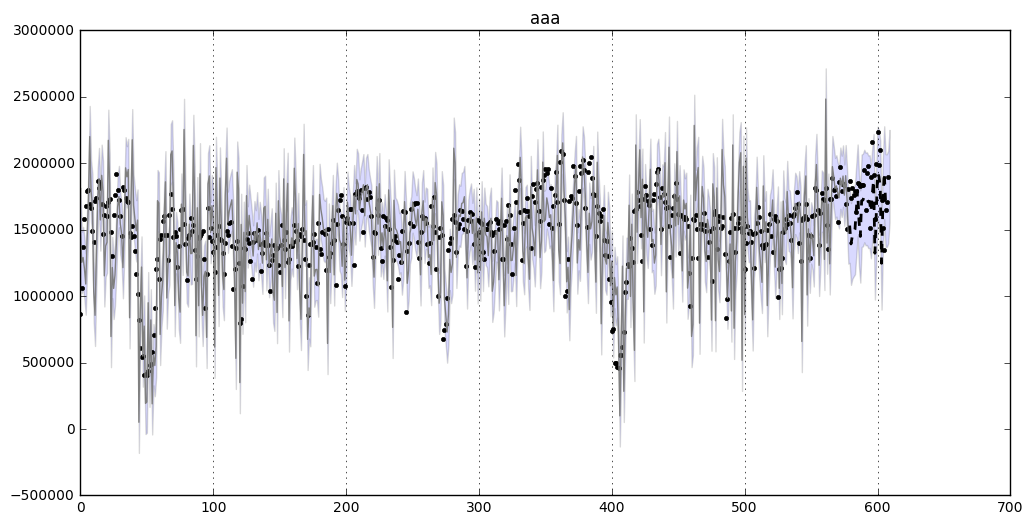

In [23]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 31
predict = res.get_prediction(end = mod.nobs+nforecast,exog = weather.iloc[578:610,:2])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha = 0.5)

# Graph
fig,ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(np.arange(609),list(data_Org.sum()),'k.')
#plot
ax.plot(idx[:-nforecast],predict.predicted_mean[:-nforecast],'gray')
ax.plot(idx[-nforecast:-1],predict.predicted_mean[-nforecast:-1],'k--',linestyle = '--',
       linewidth = 2)
ax.fill_between(idx,predict_ci.iloc[:,0],predict_ci.iloc[:,1],alpha = 0.15)

ax.set(title = 'aaa')

### model selection

In [24]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
aic_full = pd.DataFrame(np.zeros((30,30)),dtype = float)
for p in range(30):
    for q in range(30):
        if p == 0 and q == 0:
            continue
        print(p,q)
        #Estimate the mdoel
        mod = sm.tsa.statespace.SARIMAX(endog,exog,order = (p,0,q),
                                        enforce_invertibility = False)
        try:
            res = mod.fit(disp = False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
